<a href="https://colab.research.google.com/github/NikolaevMikhailRoma/ML_projects/blob/master/ML_mnist_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs

In [11]:
# Работа с операционной системой
import os

# Работа с массивами данных
import numpy as np

# Работа с таблицами
import pandas as pd

# Основные слои
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization

# класс для использования Functional API
from tensorflow.keras import Model

# Оптимизаторы для обучения модели
from tensorflow.keras.optimizers import Adam

# Функции-утилиты
from tensorflow.keras import utils

# Готовые датасеты
from tensorflow.keras.datasets import mnist, fashion_mnist

# Коллбэки для выдачи информации в процессе обучения
from tensorflow.keras.callbacks import LambdaCallback

# Отрисовка изображения
from tensorflow.keras.preprocessing import image

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split

# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error

# Отрисовка графиков
import matplotlib.pyplot as plt

import random
import time
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


%matplotlib inline

# Service functions

In [14]:
# Функция сборки сверточного автокодировщика
def create_base_ae(in_shape):
    # Энкодер, вход нейросети
    img_input = Input(in_shape)

    # Энкодер, первый блок
    # 1.1. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input)
    # 1.2. Нормализация
    x = BatchNormalization()(x)
    # 1.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # 1.4. Нормализация
    x = BatchNormalization()(x)
    # 1.5. Снижение размерности и обобщение данных
    x = MaxPooling2D()(x)

    # Энкодер, второй блок
    # 2.1. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 2.2. Нормализация
    x = BatchNormalization()(x)
    # 2.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 2.4. Нормализация
    x = BatchNormalization()(x)


    # На выходе кодировщика и на входе декодировщика z - вектор латентного пространства
    # 2.5. Снижение размерности и обобщение данных
    z = MaxPooling2D()(x)


    # Декодер, первый блок
    # 1.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z)
    # 1.2. Нормализация
    x = BatchNormalization()(x)
    # 1.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.4. Нормализация
    x = BatchNormalization()(x)
    # 1.5. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.6. Нормализация
    x = BatchNormalization()(x)

    # Декодер, второй блок
    # 2.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
    # 2.2. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # 2.4. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.5. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # 2.6. Нормализация
    x = BatchNormalization()(x)

    # Декодер, финальный слой двумерной свертки, выдающий итоговое изображение
    outputs = Conv2D(in_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    # Сборка модели, на входе оригинальное изображение, на выходе - сжатое-восстановленное
    model = Model(inputs=img_input, outputs=outputs)

    # Компиляция сети, назначение оптимизатора Adam + среднеквадратическая ошибка
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Возврат готовой модели
    return model

# Функция последовательного вывода нескольких изображений для сравнения
def plot_images(x_data, pred, n=5):

    plt.figure(figsize=(14, 7))                     # Размер полотна

    for i in range(1, n + 1):                              # Повтор n раз:
        index = np.random.randint(0, pred.shape[0]) # Выбор случайного индекса

        # Показ картинки с индексом index из набора x_data
        ax = plt.subplot(2, n, i)               # Картинка располагается в верхнем ряду
        plt.imshow(x_data[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Показ картинки с тем же индексом из предсказания автокодировщика
        ax = plt.subplot(2, n, i + n)           # Картинка располагается в нижнем ряду
        plt.imshow(pred[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

# Data processing: Добавляем черные квадраты в мнист. на у подаются не измененные данные

(70000, 28, 28, 1) (70000, 28, 28, 1)


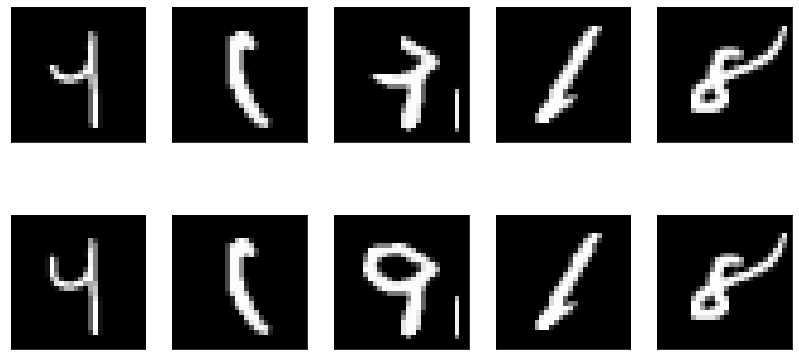

Operation_time = 1


In [40]:
curr_time = time.time()

# Загрузка данных из базы с готовой разбивкой на train/test
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

x_empty = np.expand_dims(np.vstack([x_train_mnist, x_test_mnist]), axis = 3)

y = x_empty.copy()

size_of_square = 8

height, weight = x_empty.shape[1], x_empty.shape[2]
def black_square(x):
    h = random.randint(0, height-size_of_square)
    w = random.randint(0, weight-size_of_square)
    new_x = x
    new_x[h:h+size_of_square, w:w+size_of_square,] = 0
    return new_x
x = np.array([black_square(x) for x in x_empty])
print(x.shape, y.shape)

plot_images(x, y, n=5)
print(f'Operation_time = {round(time.time() - curr_time)}')

In [41]:
# Приведение всех картинок к нужному типу
x = x.astype('float32')/255.
y = y.astype('float32')/255.

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                  y,
                                                  # stratify=y_data,
                                                  test_size=0.1)

In [45]:
x_train.shape

(63000, 28, 28, 1)

# Build, fit model and visualizate predict

In [46]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.1, 
                                      patience=1, 
                                      verbose=0,
                                      min_lr=0.000001)
earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

ae_mnist = create_base_ae(x_train.shape[1:])
# Обучение модели автокодировщика, на входе и выходе одни и те же данные
history = ae_mnist.fit(x_train, y_train,
                       epochs=50,
                       batch_size=256,
                       callbacks=[
                            earlystop, 
                           reduceLROnPlateau, 
                           #  model_checkpoint_callback
                             ],
                       validation_data = (x_test, y_test))

Epoch 1/50
247/247 [==============================] - 13s 49ms/step - loss: 0.0230 - val_loss: 0.1051 - lr: 0.0010
Epoch 2/50
247/247 [==============================] - 12s 47ms/step - loss: 0.0070 - val_loss: 0.0280 - lr: 0.0010
Epoch 3/50
247/247 [==============================] - 11s 46ms/step - loss: 0.0055 - val_loss: 0.0086 - lr: 0.0010
Epoch 4/50
247/247 [==============================] - 11s 46ms/step - loss: 0.0050 - val_loss: 0.0051 - lr: 0.0010
Epoch 5/50
247/247 [==============================] - 12s 48ms/step - loss: 0.0046 - val_loss: 0.0047 - lr: 0.0010
Epoch 6/50
247/247 [==============================] - 11s 46ms/step - loss: 0.0043 - val_loss: 0.0048 - lr: 0.0010
Epoch 7/50
247/247 [==============================] - 12s 47ms/step - loss: 0.0038 - val_loss: 0.0040 - lr: 1.0000e-04
Epoch 8/50
247/247 [==============================] - 12s 47ms/step - loss: 0.0038 - val_loss: 0.0040 - lr: 1.0000e-04
Epoch 9/50
247/247 [==============================] - 12s 47ms/step - lo

KeyboardInterrupt: ignored

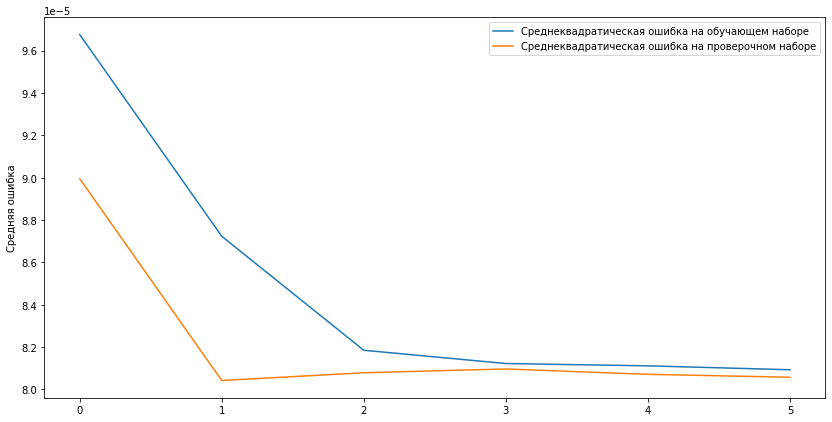

In [47]:
# Вывод графиков процесса обучения
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][2:],
         label='Среднеквадратическая ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][2:],
         label='Среднеквадратическая ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [48]:
# Получение предсказания автокодировщика на тренировочной и тестовой выборках
pred_train_mnist = ae_mnist.predict(x_train)
pred_test_mnist = ae_mnist.predict(x_test)

219/219 [==============================] - 1s 3ms/step


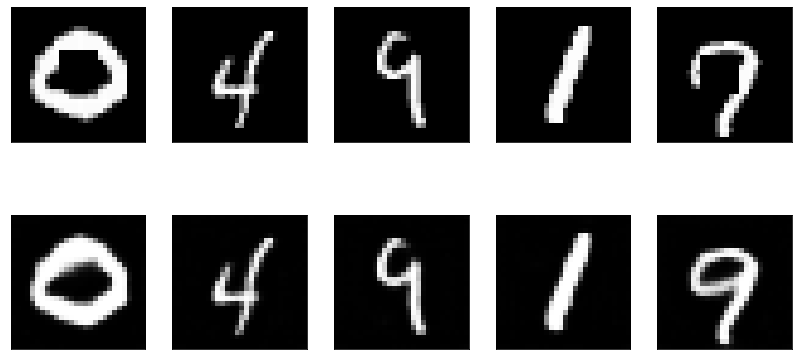

In [57]:
# Сравнение исходных и восстановленных картинок из тестовой выборки
plot_images(x_test, pred_test_mnist)